k-means ensemble은 여러 번의 k-means clustering을 통하여 ball shaped이 아닌 데이터의 군집을 찾을 수 있는 방법론이다. Jain (2010)은 아래의 그림처럼, 한 번의 클러스터링을 통하여 같은 label을 가지는 점들끼리의 co-occurance를 계산한다. 여러 번의 k-means를 수행하여 co-occurance 횟수를 새로운 n by n의 행렬로 저장한다. 이 때 각 k-means의 k가 반드시 같을 필요도 없다. 아래 그림처럼 어떨 때에는 2로 혹은 3으로 해도 좋다. 

이 행렬은 각 데이터의 co-occurrance 기준의 새로운 representation으로 생각해도 되며, 더 직접적으로는 데이터간의 similarity score이다. (Jain, 2010에서는 similarity score로 정의하였고, 이 튜토리얼에서도 그렇게 이용한다)

![ensemble_frame](figures/kmeans_ensemble.png)

여러 번 같은 label을 가지는 두 데이터는 서로 가깝게 위치하기 때문에 similarity가 높아진다는 것인데, 이때에는 한 점 i를 기준으로 global 하게 모든 다른 점 j를 고려하는 것이 아니게 된다. co-occurance matrix는 마치 RBF kernel matrix와도 비슷한 모양을 보인다. 

우리는 kmeans_ensemble을 통하여 위 그림과 같이 여러 번의 k-means 결과를 바탕으로 co-occurance matrix를 구한 뒤, 이를 similarity matrix로 이용하는 single linkage hierarchical clustering을 수행한다. 그 결과는 아래의 1000 points 그림이 그 다음의 두 개의 군집으로 나뉘어진다. 

[1] Jain, A. K. (2010). Data clustering: 50 years beyond K-means. Pattern recognition letters, 31(8), 651-666. ISO 690

1000 points


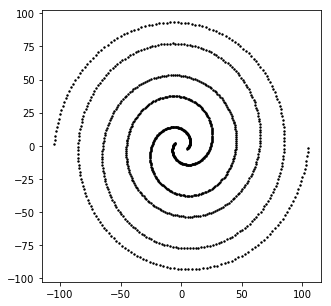

Ideal clustering results that we want


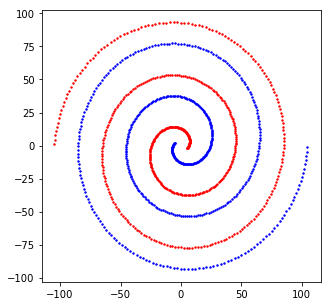

데이터를 생성하기 위한 코드이다. 각 클래스별로 500개씩의 데이터를 생성하는데, 회오리가 한 바퀴 도는 동안 200개의 점이 생성되도록 각속도 (delta)를 설정하였으며, 이 때 각 점의 radius는 get_r이라는 함수로 정의하였다. 

하나의 클래스에 대한 데이터를 만든 다음, x.reverse()를 수행하는데, 이는 x[n_data-1]와 x[n_data]가 각 클래스의 첫 시작 점이도록 만들기 위함이다. 뒤에서 co-occurance matrix를 그려보면 reverse를 하였을 때 해석이 편하다. 

In [1]:
from math import sqrt
import numpy as np

n_data = 500
delta = 2 * np.pi / 200
x_delta = 2
def get_r(i, factor=.2):
    return 5 + i * factor

x = []
for i in range(n_data):
    r = get_r(i)
    theta = delta * i
    x.append((r * np.cos(theta), r * np.sin(theta) - x_delta))
x.reverse()
    
for i in range(n_data):
    r = get_r(i)
    theta = delta * i + np.pi
    x.append((r * np.cos(theta), r * np.sin(theta) + x_delta))

x = np.asarray(x)

matplotlib을 이용하여 그림을 그리기 위해 matplotlib inline을 실행한다. 

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

실제로 그려진 데이터는 아래와 같다. 맨 위의 작은 그림이다. 

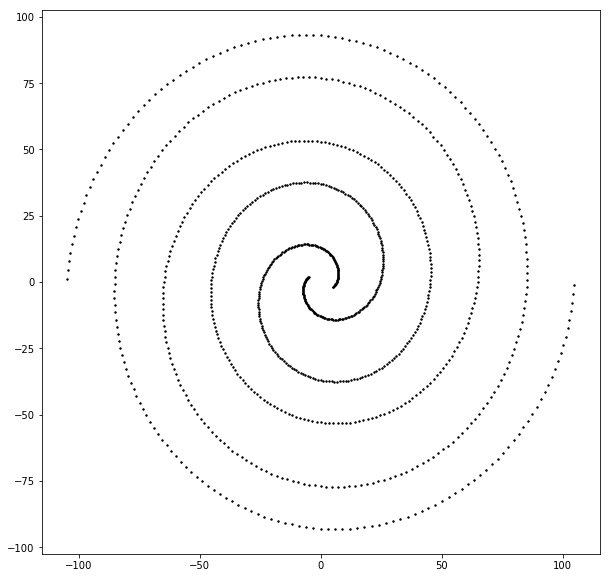

In [3]:
plt.figure(figsize=(10,10))
plt.scatter(x[:,0], x[:,1], color='black', s=2)
plt.show()

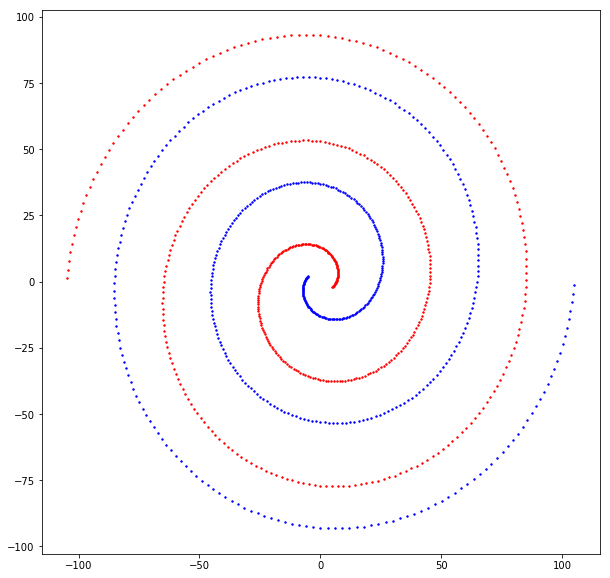

In [4]:
plt.figure(figsize=(10,10))
plt.scatter(x[:n_data,0], x[:n_data,1], color='red', s=2)
plt.scatter(x[n_data:,0], x[n_data:,1], color='blue', s=2)
plt.show()

생성된 데이터간의 Euclidean과 Cosine distance를 계산하였다. 흰색일수록 가깝다는 이미이다. 

In [5]:
from sklearn.metrics import pairwise_distances

(그림의 정중앙) 원점 근처의 두 점은 실제로 거리가 가깝기 때문에 하얗게 드러나며, 기울기 -1의 방향으로 진한 하얀 선이 존재한다. 이는 연속된 점들끼리는 Euclidean 기준으로 매우 가깝다는 의미이다. 그 다음에는 이에 평행하게 사선의 희미한 흰색 띠가 생성된다. 이 점들은 비슷한 theta를 지니는 점이다. 하지만 radius가 차이가 나기 때문에 하얀색의 정도가 조금 옅음을 알 수 있다. 

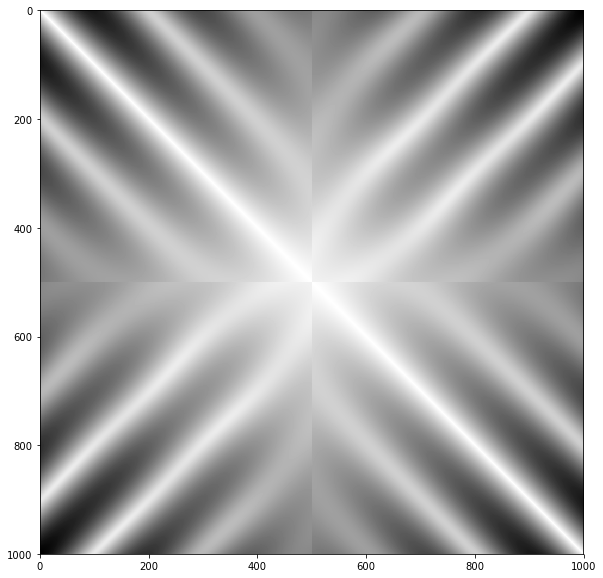

In [6]:
euclidean = pairwise_distances(x, x, metric='euclidean')
plt.figure(figsize=(10,10))
plt.imshow(euclidean, cmap='binary')

Cosine의 경우에는 radius가 고려되지 않기 때문에 위 그림에서 어느 정도 하얀 부분은 완전 하얗게, 그러지 않은 부분은 완점 검게 칠해진다.

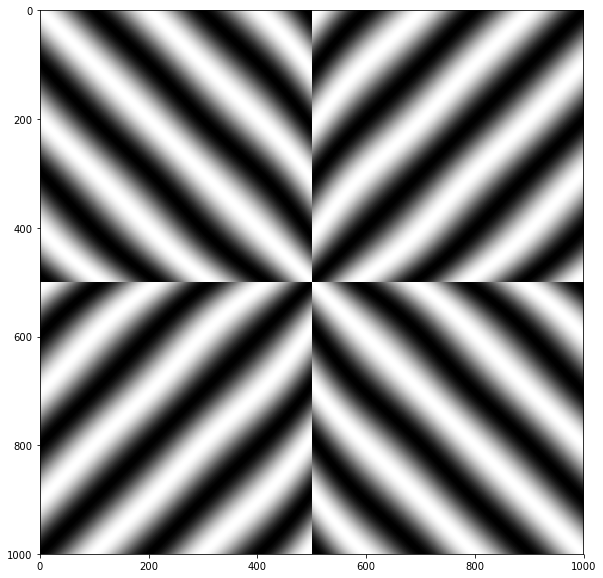

In [7]:
cosine = pairwise_distances(x, x, metric='cosine')
plt.figure(figsize=(10,10))
plt.imshow(cosine, cmap='binary')

이러한 데이터에 대하여 k-means ensemble을 수행한다. 미리 만들어둔 구현체를 이용하였다. KMeansEnsemble는 생성 시, 두 가지 parameters를 받는다. 

    n_ensembles: ensemble 횟수로, k-means를 몇 번 학습하는지에 대한 횟수
    n_clusters: ensemble을 위해 한 번 수행하는 k-means의 k값

ensemble 도중 각 k-means의 클러스터링 결과를 디버깅 하려면 KMeansEnsemble.ensemble(debug_samples=5)을 입력한다. 이는 최초 debug_samples 번의 k-means의 label을 yield 해준다. debug_sample는 기본값이 0으로 되어 있으며, 이 때에는 어떤 값도 yield, return 되지 않는다. 

    kmeans_ensemble.ensemble(x, debug_samples=5)

아래 예제는 500번의 k-means를 수행하는데, 각 횟수마다 1,000개의 데이터에 대하여 100개의 클러스터를 생성하여 같은 label을 가지는 데이터간의 co-occurrance를 계산한다. n_clusters가 커서 정말로 근처에 있는 점들끼리 같은 군집으로 묶임을 확인할 수 있다. (그리고, k-means ensemble에서는 이 n_clusters가 학습의 핵심이다. 곧바로 뒤에어 이야기를 이어가자)

그리고 우리가 원하는 최종적인 클러스터의 개수는 2이기 때문에 KMeansEnsemble.ensemble(n_final_clusters=2)로 설정하자 

    kmeans_ensemble.ensemble(x, n_final_clusters=2)

#iter = 0


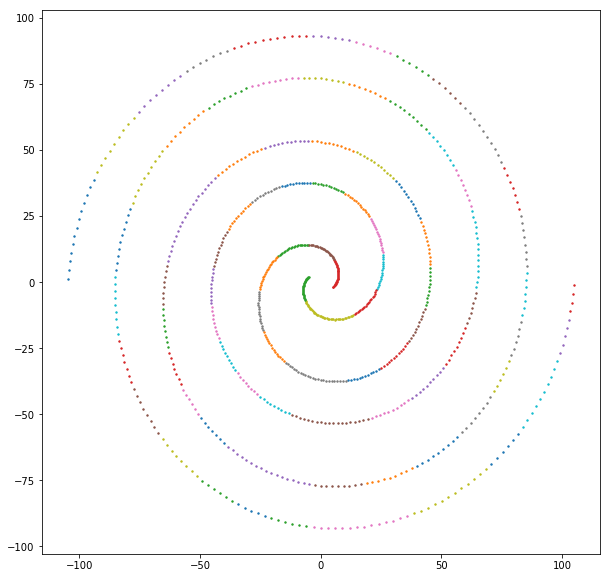

#iter = 1


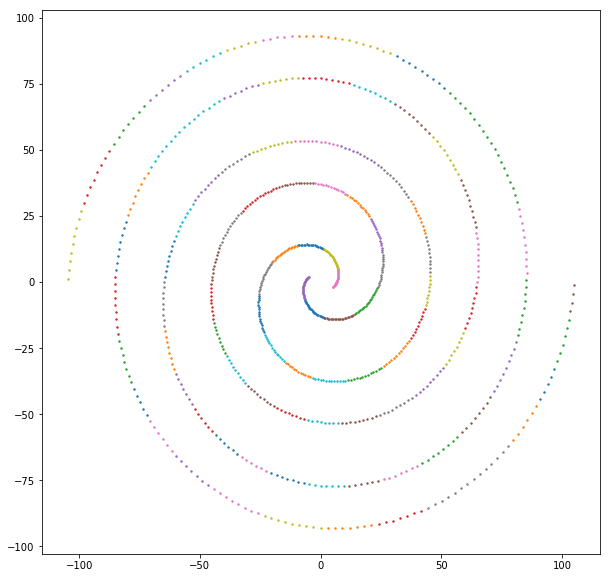

#iter = 2


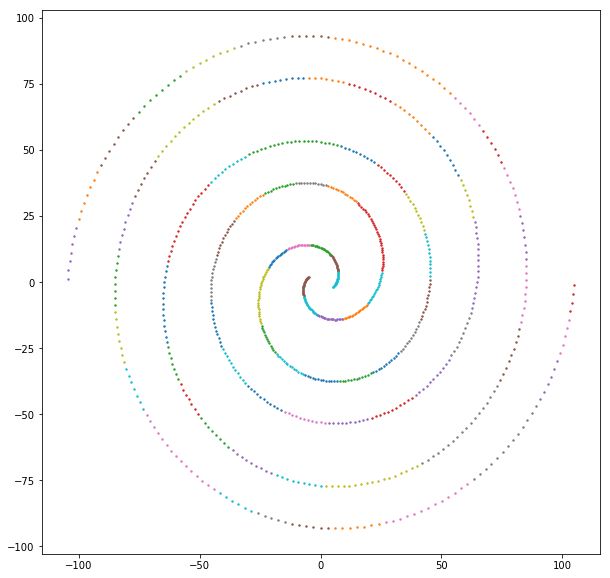

#iter = 3


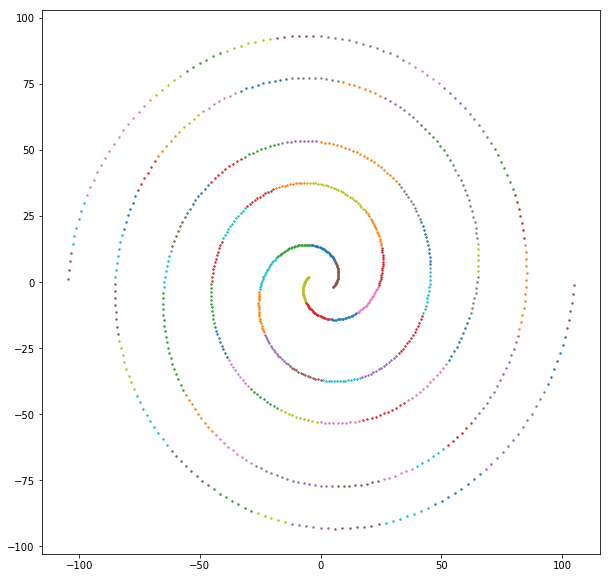

#iter = 4


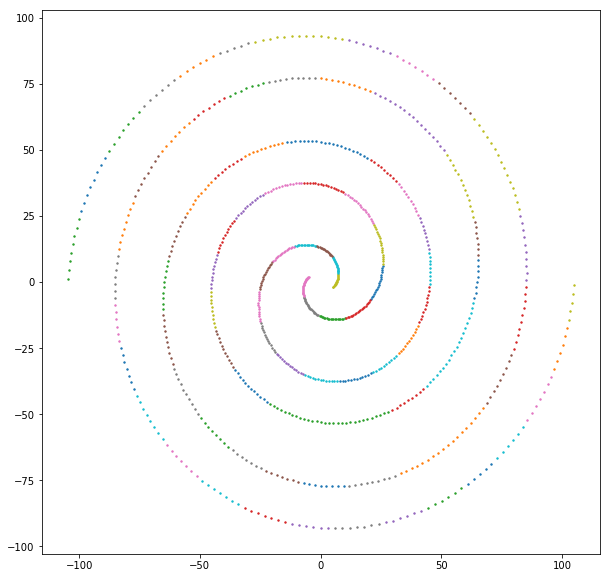

/home/analyzer/anaconda3/envs/server_ver2/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [8]:
import sys
sys.path.append('../')
from soykmeans import KMeansEnsemble

kmeans_ensemble = KMeansEnsemble(n_ensembles=500, n_clusters=100)

for n_iter, labels in enumerate(kmeans_ensemble.ensemble(x, n_final_clusters=2, debug_samples=5)):
    print('#iter = %d' % n_iter)

    plt.figure(figsize=(10,10))
    for label in set(labels):
        idx = [i for i, label_ in enumerate(labels) if label_ == label]
        plt.scatter(x[idx,0], x[idx,1], s=2)
    plt.show()

KMeansEnsemble.x_final은 co-occurance 횟수를 n_ensembles로 나눈 값이다. [0, 1]사이의 값이다. 이를 HeatMap으로 표현하면 아래와 같다. 흰색일수록 같은 label을 가졌다는 의미이다. 

가운데를 기점으로 2사분면과 4사분면은 크게 절단된 느낌이 난다. 절단이 된 것은, 위의 그림에서 볼 수 있듯이 가운데에 있는 두 클래스의 점들이 절대 하나의 군집으로 묶인 적이 없기 때문이다. 그리고 각각 2, 4사분면의 점들끼리는 사선 방향으로 점들이 어느 정도 이어져 있는 것이 보인다. 그림 중심에서 흰색이 넓게 보이는 것은 우리의 데이터가 원점 근처에 많은 점들을 생성했기 때문이다. 

이 similarity score 자체를 벡터로 이용할 수도 있다. 각 row는 한 점 i에 대한 다른 점과의 유사도 벡터가 되는 것이다. 

혹은 이대로 similarity matrix를 hierarchical clustering에 입력할 수도 있다. KMeansEnsemble은 그렇게 만들어져있다. 

Heatmap of coccurrance matrix


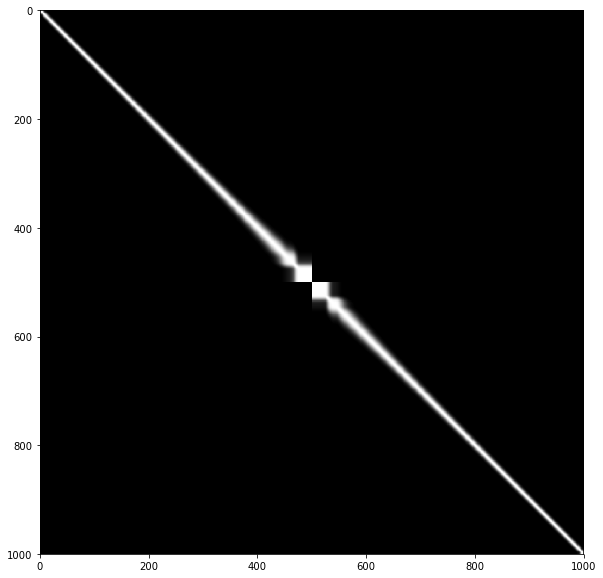

In [12]:
from sklearn.metrics import pairwise_distances

cooccurrance = kmeans_ensemble.x_final
cosine = pairwise_distances(cooccurrance, cooccurrance, metric='cosine')
print('Heatmap of coccurrance matrix')
plt.figure(figsize=(10,10))
plt.imshow(cosine, cmap='binary')

위 co-occurance matrix를 기반으로 클러스터의 개수가 2가 될 때까지 hierarchical clustering을 수행하였다. 그 결과는 KMeansEnsemble.labels에 저장되어 있다. 이를 바탕으로 다시 그림을 그려보면 원하는 형태로 군집이 만들어져 있음을 확인할 수 있다. 

이와 같은 결과가 나올 수 있었던 이유는 가운데의 두 점 (각 클래스의 시작점)에 대한 co-occurance가 0이기 때문이다. 즉, 두 점은 어떤 일이 있어도 이어질 수 없었고, 두 개의 군집을 만든다면 서로 연결성이 있는 두 집합, 2 혹은 4 사분면의 점들을 하나로 이으면 되기 떄문이다. 

result of clustering ensemble


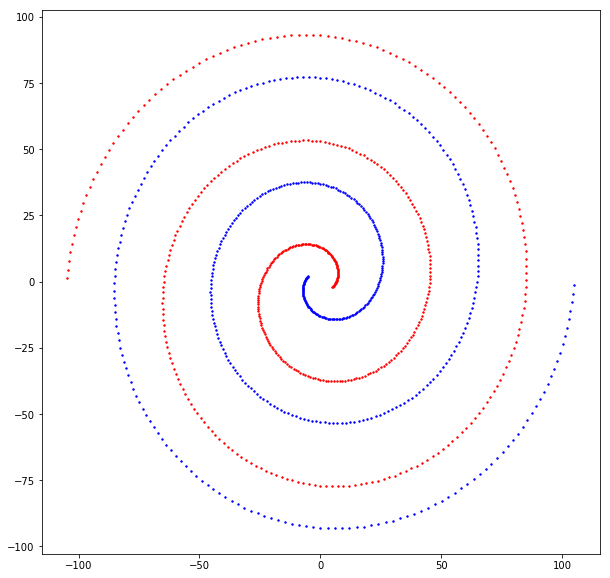

In [13]:
labels = kmeans_ensemble.labels
red_idx = [i for i, label in enumerate(labels) if label == 0]
blue_idx = [i for i, label in enumerate(labels) if label == 1]

print('result of clustering ensemble')
plt.figure(figsize=(10,10))
plt.scatter(x[red_idx,0], x[red_idx,1], color='red', s=2)
plt.scatter(x[blue_idx,0], x[blue_idx,1], color='blue', s=2)
plt.show()

이런 manifold 구조는 Embedding 알고리즘으로 손쉽게 시각화 할 수도 있다. 각 클래스의 점들이 촘촘하게 이어져 있기 때문에 k-nearest neighbors를 기반으로 하는 LLE의 경우 파란색과 빨간색의 클래스를 잘 분리해놓는다. 

이 때 파란선의 길이와 빨간선의 길이는 어떤 의미도 갖지 않는다. 애초에 파란색과 빨간색은 연결된 적이 없었기 때문에 이 둘은 한 그림 위에 그려지지만, 서로 다른 세계이다. 각 색깔별로 점들간의 간격만 잘 맞으면 된다. 

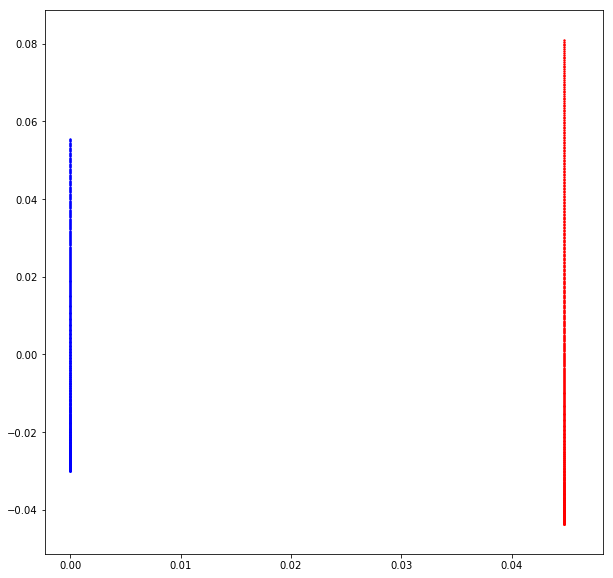

In [21]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2)
y_lle = lle.fit_transform(x)

plt.figure(figsize=(10,10))
plt.scatter(y_lle[:n_data,0], y_lle[:n_data,1], color='red', s=2)
plt.scatter(y_lle[n_data:,0], y_lle[n_data:,1], color='blue', s=2)
plt.show()

그렇기 때문에 같은 데이터로 3번 LLE를 학습할 때마다 두 선의 길이는 제각각 달라진다. 

iteration 1


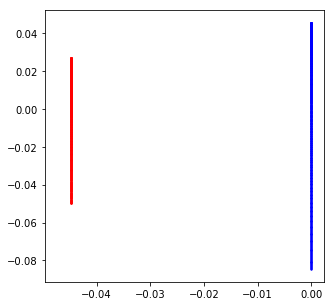

iteration 2


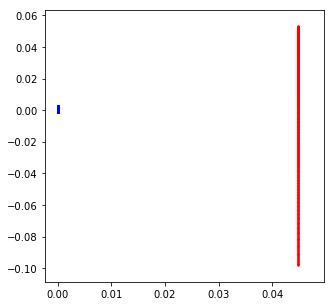

iteration 3


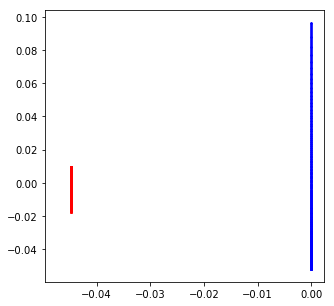

In [4]:
for n_iter in range(3):
    lle = LocallyLinearEmbedding(n_components=2)
    y_lle = lle.fit_transform(x)
    
    print('iteration %d' % (n_iter + 1))
    plt.figure(figsize=(5,5))
    plt.scatter(y_lle[:n_data,0], y_lle[:n_data,1], color='red', s=2)
    plt.scatter(y_lle[n_data:,0], y_lle[n_data:,1], color='blue', s=2)
    plt.show()

ISOMAP도 위 데이터의 구조를 매우 잘 잡아낸다. ISOMAP은 각 클래스의 시작점이 연결이 되었던듯 하다 (확인하지 않은 사실이다). 여하튼 각 클래스 별로는 납득될만한 모양으로 embedding이 되고 있다. 

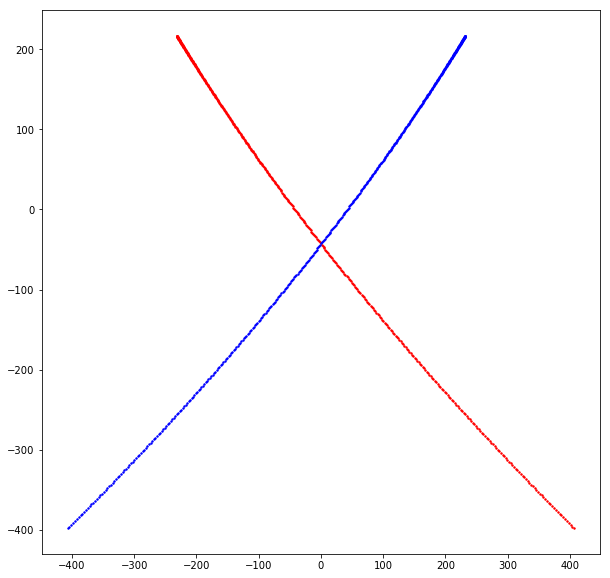

In [15]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
y_isomap = isomap.fit_transform(x)
plt.figure(figsize=(10,10))
plt.scatter(y_isomap[:n_data,0], y_isomap[:n_data,1], color='red', s=2)
plt.scatter(y_isomap[n_data:,0], y_isomap[n_data:,1], color='blue', s=2)
plt.show()

RBF kernel을 이용한 Kernel PCA를 학습한 결과 역시 원점 근처의 점들에서 두 클래스를 구분하기 어려워하며, 그 외의 점들에 대해서는 잘 퍼져 구분되고 있다. 

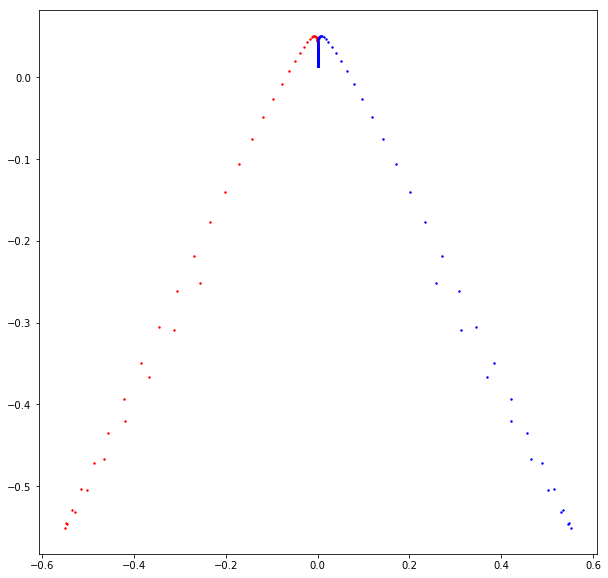

In [16]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf')
y_kpca = kpca.fit_transform(x)
plt.figure(figsize=(10,10))
plt.scatter(y_kpca[:n_data,0], y_kpca[:n_data,1], color='red', s=2)
plt.scatter(y_kpca[n_data:,0], y_kpca[n_data:,1], color='blue', s=2)
plt.show()

하지만 t-SNE는 매우 어려워하는데, LLE, ISOMAP은 명시적으로 k-nearest neighbors의 정보만을 이용한다. 하지만 t-SNE는 entropy 기준으로 (perplexity) 어느 정도의 주변 데이터와의 거리를 모두 고려하는데, 그렇기 때문에 한 바퀴 넘어 다른 클래스의 점들이 자신과 가깝다고 착각하게 된다. 그래서 서로 평행하면서도 비슷한 모양으로 빨간색과 파란색의 점들이 나타난다. 

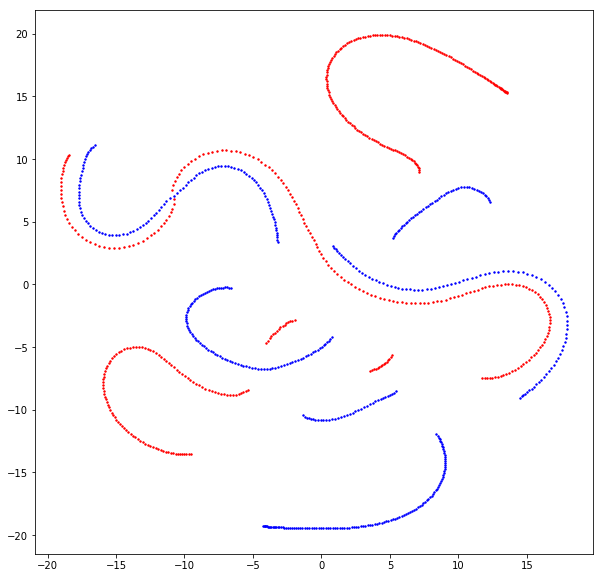

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)
y_tsne = tsne.fit_transform(x)
plt.figure(figsize=(10,10))
plt.scatter(y_tsne[:n_data,0], y_tsne[:n_data,1], color='red', s=2)
plt.scatter(y_tsne[n_data:,0], y_tsne[n_data:,1], color='blue', s=2)
plt.show()

t-SNE를 학습할 때 서로 영향을 받는 점들의 개수를 직접적으로 컨트롤 할 수는 없지만, perplexity를 이용하여 그 범위를 조절할 수는 있다. perplexity는 한 점 기준으로 고려하는 점들의 영역의 크기로 해석할 수 있다 (비유적인 표현이며, 정확한 표현은 아니다).

perplexity의 default value는 30인데, 이를 5로 줄여서 학습하면 아래와 같이 된다. perplexity=30일 때 보다는 조금 더 소프트한 느낌이지만, 부분부분이 단절되어서 임베딩이 되고 있고, 단절된 각 부분 (파편)들 끼리는 선형으로 이어져 있는 모습이 보인다. 

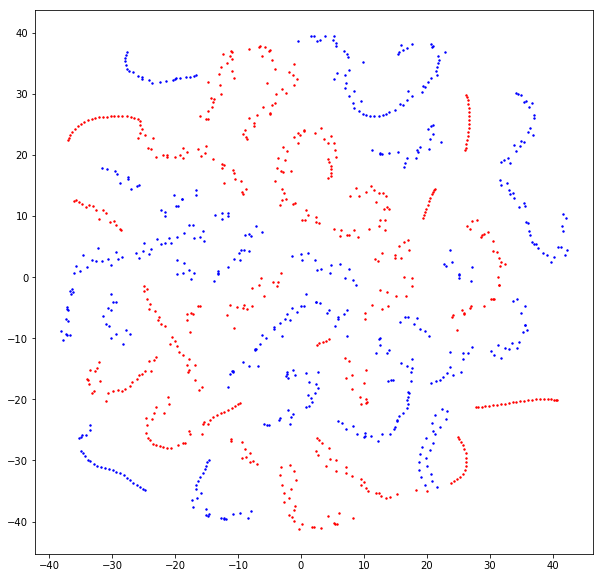

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5)
y_tsne = tsne.fit_transform(x)
plt.figure(figsize=(10,10))
plt.scatter(y_tsne[:n_data,0], y_tsne[:n_data,1], color='red', s=2)
plt.scatter(y_tsne[n_data:,0], y_tsne[n_data:,1], color='blue', s=2)
plt.show()

좀 더 perplexity를 줄일 경우에는 오히려 너무 가까운 점들만을 고려하여 아예 결과가 망쳐짐도 확인할 수 있다. 사실 이 데이터는 t-SNE가 임베딩 하기에 꾀나 까다로운 데이터이다. 

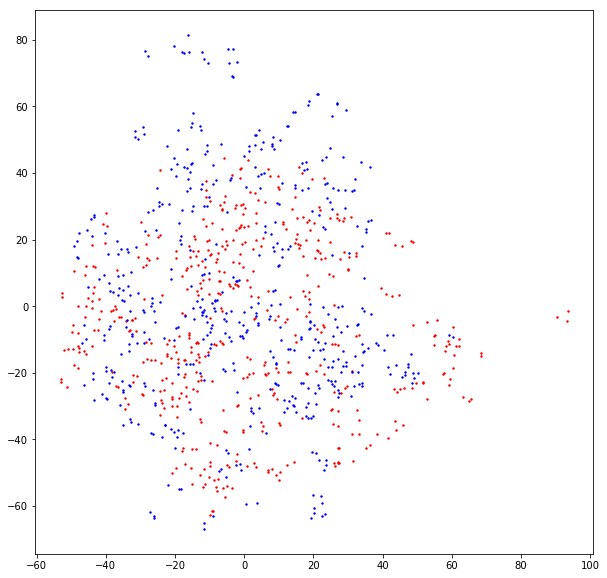

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=0.1)
y_tsne = tsne.fit_transform(x)
plt.figure(figsize=(10,10))
plt.scatter(y_tsne[:n_data,0], y_tsne[:n_data,1], color='red', s=2)
plt.scatter(y_tsne[n_data:,0], y_tsne[n_data:,1], color='blue', s=2)
plt.show()

앞에서 k-means ensemble을 하기 위해서는 각 개별 k-means의 k를 크게 설정해야 한다고 언급하였다. 만약 Jain (2010)의 예시 그림 처럼 n_cluster를 작게 잡으면 어떨까? n_clusters=5로 설정하여 같은 작업을 수행하였다. 

그 결과, 클래스 종류에 관계없이 가운데 부분이 하나의 군집을, 그리고 가운데를 제외한 나머지 부분이 4등분 되어 군집으로 잡히고 있음을 볼 수 있다. 하나의 군집이 크기 때문에 선을 교차해서라도 하나의 군집을 만들게 된 것이고, 이는 다른 클래스의 데이터들이 같은 label을 가지도록 만든다. 

#iter = 0


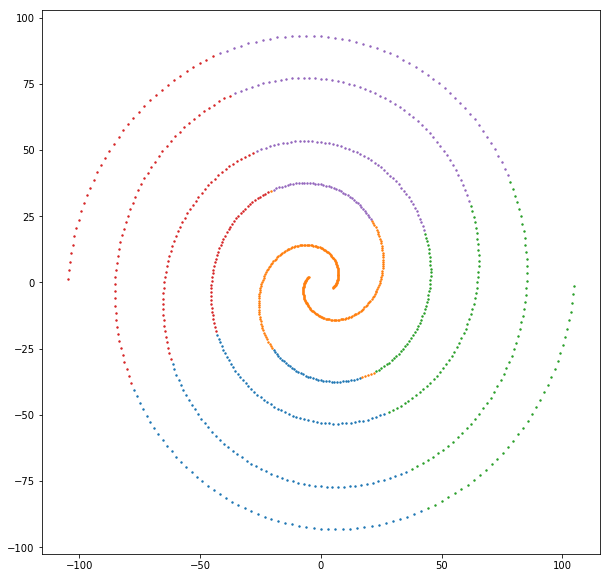

#iter = 1


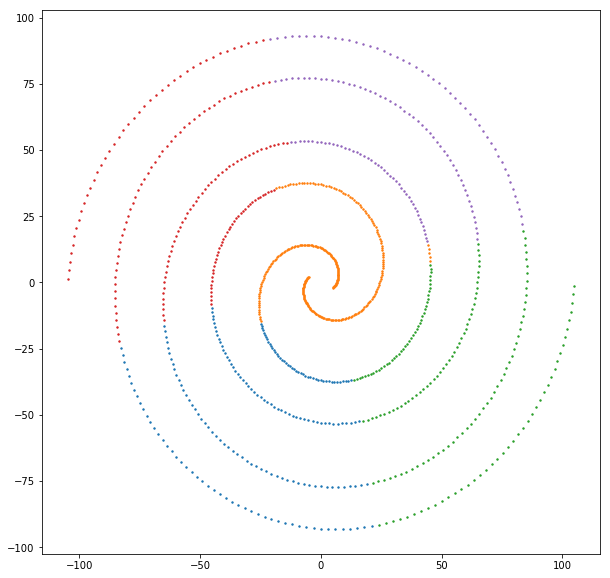

#iter = 2


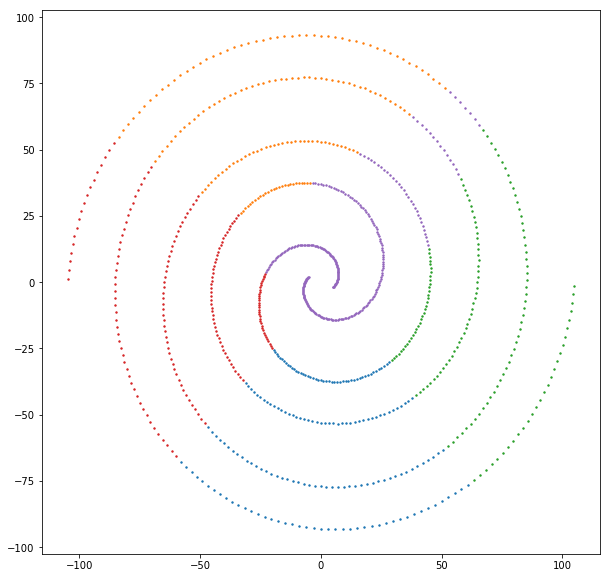

/home/analyzer/anaconda3/envs/server_ver2/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [17]:
import sys
sys.path.append('../')
from soykmeans import KMeansEnsemble

kmeans_ensemble = KMeansEnsemble(n_ensembles=500, n_clusters=5)

for n_iter, labels in enumerate(kmeans_ensemble.ensemble(x, n_final_clusters=2, debug_samples=3)):
    print('#iter = %d' % n_iter)

    plt.figure(figsize=(10,10))
    for label in set(labels):
        idx = [i for i, label_ in enumerate(labels) if label_ == label]
        plt.scatter(x[idx,0], x[idx,1], s=2)
    plt.show()

Co-occurance matrix를 살펴보면 실제로 가운데의 점들끼리 하나의 군집으로 뭉쳐져 있음을 볼 수 있다. 심지어 similarity가 sparse 하지도 않는다. 각각의 k-means의 k를 작게 잡는 것은 마치 해상도를 낮춰서 데이터를 살펴보는 것과 같다. 

Heatmap of coccurrance matrix


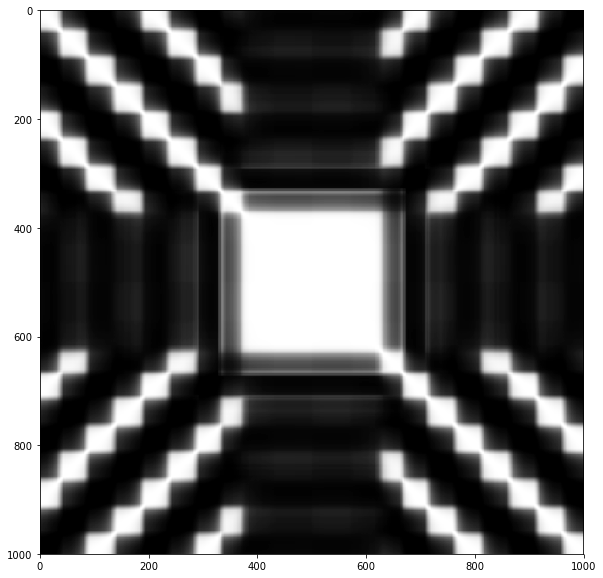

In [19]:
cooccurrance = kmeans_ensemble.x_final
cosine = pairwise_distances(cooccurrance, cooccurrance, metric='cosine')
print('Heatmap of coccurrance matrix')
plt.figure(figsize=(10,10))
plt.imshow(cosine, cmap='binary')

그리고 당연하게도, 이 co-occurance를 similarity score로 이용할 경우에는 클러스터가 제대로 만들어지지 않는다. 심지어 similarity score matrix의 sparsity도 매우 낮아서 계산까지 오래 걸린다. 즉 개별 k-means의 군집의 수를 크게 잡음으로써, 좀 더 정밀한 similarity를 측정해야만 ensemble의 결과가 좋아진다. 

result of clustering ensemble


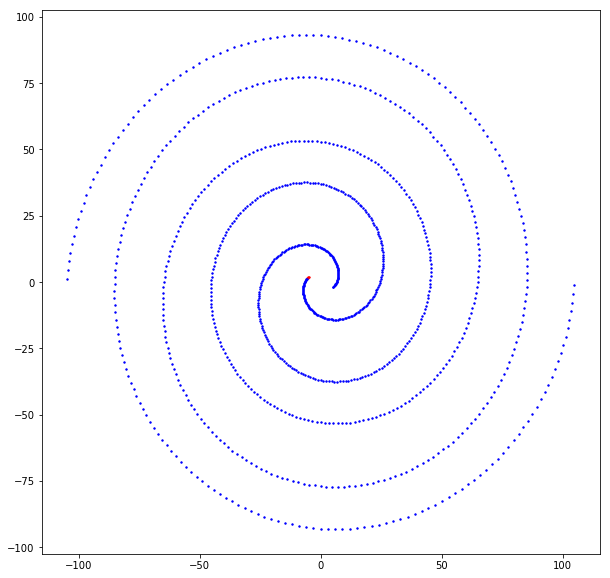

In [18]:
labels = kmeans_ensemble.labels
red_idx = [i for i, label in enumerate(labels) if label == 0]
blue_idx = [i for i, label in enumerate(labels) if label == 1]

print('result of clustering ensemble')
plt.figure(figsize=(10,10))
plt.scatter(x[red_idx,0], x[red_idx,1], color='red', s=2)
plt.scatter(x[blue_idx,0], x[blue_idx,1], color='blue', s=2)
plt.show()